# 日経平均株価 日足 メディアン統計

In [16]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [17]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [18]:
code = 'N225'
symbol = '^%s' % code
ticker = yf.Ticker(symbol)

In [19]:
# 日足で過去 2 年分のデータを取得
df0 = ticker.history(period='10y', interval='1d')
 
# ローソク足のチャートには、そのうち過去 1 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_1y =  datetime.timedelta(days=365)
df = df0[df0.index >= dt_last - tdelta_1y]
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-10 00:00:00+09:00,39582.328125,39708.699219,39510.480469,39581.808594,97400000,0.0,0.0
2024-04-11 00:00:00+09:00,39090.679688,39473.480469,39065.308594,39442.628906,107000000,0.0,0.0
2024-04-12 00:00:00+09:00,39722.019531,39774.820312,39457.730469,39523.550781,107100000,0.0,0.0
2024-04-15 00:00:00+09:00,39056.929688,39232.800781,38820.949219,39232.800781,107000000,0.0,0.0
2024-04-16 00:00:00+09:00,38750.671875,38764.820312,38322.320312,38471.199219,133000000,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-04 00:00:00+09:00,34304.660156,34320.109375,33259.761719,33780.578125,227600000,0.0,0.0
2025-04-07 00:00:00+09:00,33154.968750,33158.871094,30792.740234,31136.580078,266700000,0.0,0.0
2025-04-08 00:00:00+09:00,31729.109375,33257.160156,31703.689453,33012.578125,191900000,0.0,0.0


## Moving Median

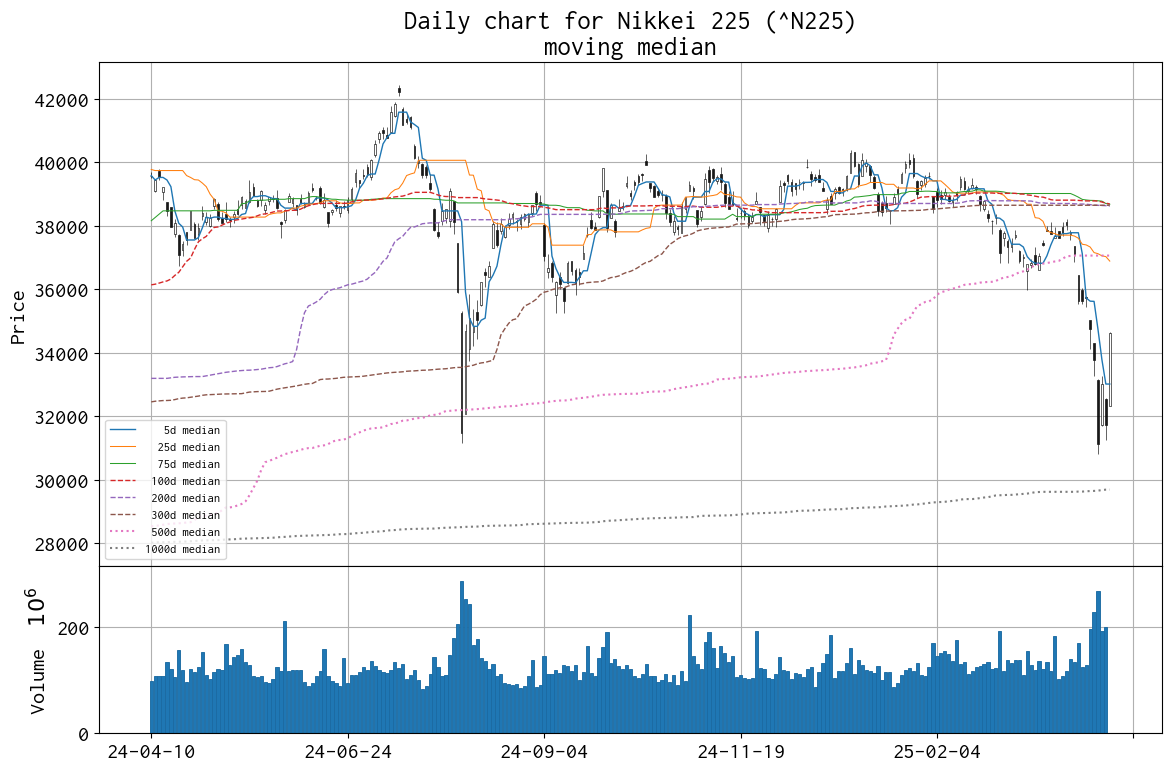

In [20]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()
mm300 = df0['Close'].rolling(300).median()
mm500 = df0['Close'].rolling(500).median()
mm1000 = df0['Close'].rolling(1000).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=1, label='   5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label='  25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label='  75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=1, linestyle='dashed', label=' 100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=1, linestyle='dashed', label=' 200d median', ax=ax[0]),
    mpf.make_addplot(mm300[df.index], width=1, linestyle='dashed', label=' 300d median', ax=ax[0]),
    mpf.make_addplot(mm500[df.index], width=1.5, linestyle='dotted', label=' 500d median', ax=ax[0]),
    mpf.make_addplot(mm1000[df.index], width=1.5, linestyle='dotted', label='1000d median', ax=ax[0]),
]   

mpf.plot(df, type='candle', style='default', volume=ax[1], datetime_format='%y-%m-%d', addplot=apds, xrotation=0, ax=ax[0])

ax[0].set_title('Daily chart for %s (%s)\nmoving median' %(ticker.info['longName'], symbol))
ax[0].legend(loc='lower left', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [21]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-09 00:00:00+09:00,32529.230469,32565.839844,31258.179688,31714.029297,199300000,0.0,0.0
2025-04-10 00:00:00+09:00,32321.210938,34639.390625,32320.660156,34609.000000,0,0.0,0.0


In [22]:
df.tail(2)['Close']

Date
2025-04-09 00:00:00+09:00    31714.029297
2025-04-10 00:00:00+09:00    34609.000000
Name: Close, dtype: float64

In [23]:
df.tail(2)['Close'].diff()

Date
2025-04-09 00:00:00+09:00            NaN
2025-04-10 00:00:00+09:00    2894.970703
Name: Close, dtype: float64

In [24]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-04-10 00:00:00+09:00    2287.789062
dtype: float64

In [25]:
df['Close'].rolling(9).median().tail()

Date
2025-04-04 00:00:00+09:00    35725.871094
2025-04-07 00:00:00+09:00    35624.480469
2025-04-08 00:00:00+09:00    35617.558594
2025-04-09 00:00:00+09:00    34735.929688
2025-04-10 00:00:00+09:00    34609.000000
Name: Close, dtype: float64

In [26]:
df['Close'].rolling(13).median().tail()

Date
2025-04-04 00:00:00+09:00    37608.488281
2025-04-07 00:00:00+09:00    37120.328125
2025-04-08 00:00:00+09:00    35725.871094
2025-04-09 00:00:00+09:00    35624.480469
2025-04-10 00:00:00+09:00    35617.558594
Name: Close, dtype: float64

In [27]:
df['Close'].rolling(26).median().tail()

Date
2025-04-04 00:00:00+09:00    37243.339844
2025-04-07 00:00:00+09:00    37137.914062
2025-04-08 00:00:00+09:00    37086.714844
2025-04-09 00:00:00+09:00    37040.685547
2025-04-10 00:00:00+09:00    36957.720703
Name: Close, dtype: float64

In [28]:
df['Close'].rolling(52).median().tail()

Date
2025-04-04 00:00:00+09:00    38190.080078
2025-04-07 00:00:00+09:00    38084.830078
2025-04-08 00:00:00+09:00    37936.355469
2025-04-09 00:00:00+09:00    37822.695312
2025-04-10 00:00:00+09:00    37792.718750
Name: Close, dtype: float64

## Robust Bollinger's bands

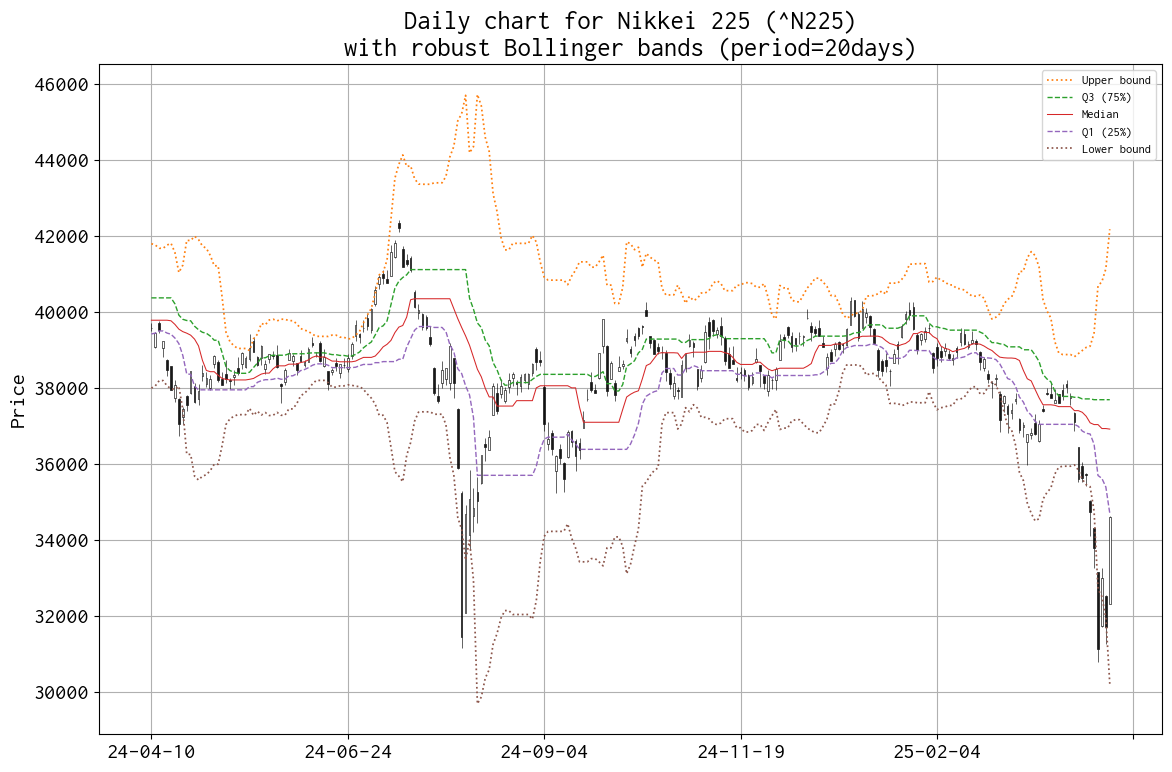

In [29]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%ddays)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%ddays)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラムと Q-Q プロット

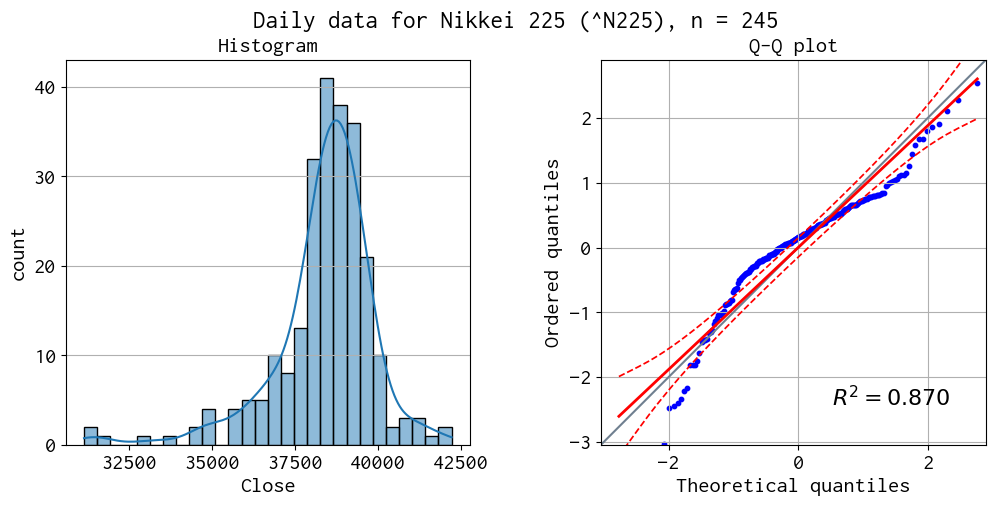

In [30]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()